In [1]:
import tensorflow as tf
import torch

import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np

from kan import *
import time

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import csv

from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression, f_regression, chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder

C:\Users\PC\anaconda3\envs\clone_gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cuda


In [3]:
# read dataset
df = pd.read_csv("Leads X Education.csv")

In [4]:
# preprocessing steps for numerical and categorical data (remove id, drop constant, replace missing value, encode, scale)
# drop id
df = df.drop(["Prospect ID", "Lead Number"], axis = 1)

# drop columns with only 1 distinct value
cat_cols = [col for col in df.select_dtypes(exclude = np.number).columns]
x = df[cat_cols].nunique()
cols_to_drop = list(x[x < 2].index)
df.drop(cols_to_drop, axis = 1, inplace = True)

# replace select to null value (later will change to Unknown)
df.replace('Select', '', inplace=True)

numeric_features = df.drop(["Converted"], axis = 1).select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

features = preprocessor.fit_transform(df)
target = df['Converted']

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=30)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=30)

train_input = torch.tensor(X_train.todense(), dtype=torch.float32).to(device)
test_input = torch.tensor(X_test.todense(), dtype=torch.float32).to(device)
val_input = torch.tensor(X_val.todense(), dtype=torch.float32).to(device)

train_label = torch.tensor(np.array(y_train).reshape(-1, 1), dtype=torch.float32).to(device)
test_label = torch.tensor(np.array(y_test).reshape(-1, 1), dtype=torch.float32).to(device)
val_label = torch.tensor(np.array(y_val).reshape(-1, 1), dtype=torch.float32).to(device)

dataset = {
    'train_input' : train_input,
    'test_input'  : test_input,
    'train_label' : train_label,
    'test_label'  : test_label,
    'val_input'   : val_input,
    'val_label'   : val_label
}

In [6]:
def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

In [7]:
torch.cuda.empty_cache()

In [8]:
st = time.time()

model = KAN(width=[dataset['train_input'].shape[1], 3, 1], device=device).to(device)
final_result = model.train(dataset, metrics=(train_acc, test_acc), device=device)

et = time.time()
duration_b4 = et-st

print("Accuracy", final_result['train_acc'][-1], final_result['test_acc'][-1])
print("Duration", duration_b4)

train loss: 1.79e-01 | test loss: 2.36e-01 | reg: 1.68e+02 : 100%|█| 100/100 [30:17<00:00, 18.17s/it

Accuracy 0.9610389471054077 0.9329004287719727
Duration 1818.3070006370544


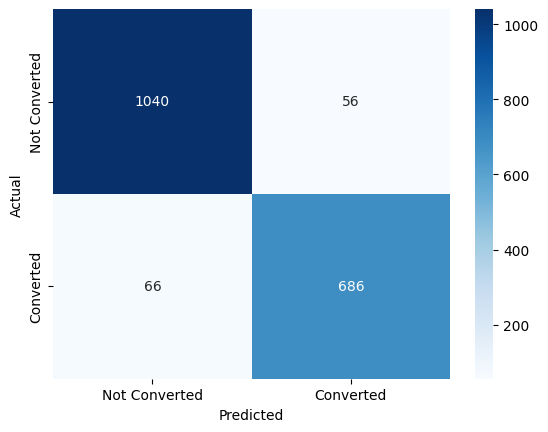

Accuracy: 0.933982683982684
Precision: 0.9245283018867925
Recall: 0.9122340425531915
F1 Score: 0.9183400267737618


In [9]:
# get predicted values
with torch.no_grad():
    test_inputs = dataset['test_input'].clone().detach().to(device)
    actual_labels = dataset['test_label'].clone().detach().to(device)
    predicted_probs = model(test_inputs)
    predicted_labels = (predicted_probs > 0.5).float()
    
y_pred = predicted_labels.cpu().numpy()
y_true = actual_labels.cpu().numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

accuracy_b4 = (tn+tp)/(tn+fp+fn+tp)
precision_b4 = tp / (tp + fp) if (tp + fp) != 0 else 0
recall_b4 = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score_b4 = 2 * (precision_b4 * recall_b4) / (precision_b4 + recall_b4) if (precision_b4 + recall_b4) != 0 else 0

# confusion matrix heatmap
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# performance metrics
print(f'Accuracy: {accuracy_b4}')
print(f'Precision: {precision_b4}')
print(f'Recall: {recall_b4}')
print(f'F1 Score: {f1_score_b4}')

In [10]:
# fine-tune grid
st = time.time()

grid_values = [1, 3, 5, 7]
results = []

for grid_val in grid_values:
    print(f"\nTraining with grid = {grid_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=grid_val, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with grid = 1


train loss: 1.83e-01 | test loss: 2.42e-01 | reg: 2.01e+02 : 100%|█| 100/100 [28:52<00:00, 17.33s/it


Train Accuracy: 0.96121931, Test Accuracy: 0.92748916, Duration: 1732.68 sec

Training with grid = 3


train loss: 1.70e-01 | test loss: 2.57e-01 | reg: 2.05e+02 : 100%|█| 100/100 [27:56<00:00, 16.77s/it


Train Accuracy: 0.96645021, Test Accuracy: 0.93235928, Duration: 1676.93 sec

Training with grid = 5


train loss: 1.61e-01 | test loss: 2.54e-01 | reg: 1.42e+02 : 100%|█| 100/100 [28:31<00:00, 17.11s/it


Train Accuracy: 0.96951658, Test Accuracy: 0.92370129, Duration: 1711.37 sec

Training with grid = 7


train loss: 1.53e-01 | test loss: 3.03e-01 | reg: 1.59e+02 : 100%|█| 100/100 [27:57<00:00, 16.77s/it

Train Accuracy: 0.97402596, Test Accuracy: 0.91829002, Duration: 1677.23 sec


In [11]:
# fine-tune k
st = time.time()

k_values = [1, 3, 5, 7]
results = []

for k_val in k_values:
    print(f"\nTraining with k = {k_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=3, k=k_val, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with k = 1


train loss: 1.64e-01 | test loss: 2.60e-01 | reg: 3.34e+02 : 100%|█| 100/100 [26:59<00:00, 16.19s/it


Train Accuracy: 0.96879512, Test Accuracy: 0.92748916, Duration: 1619.11 sec

Training with k = 3


train loss: 1.68e-01 | test loss: 2.68e-01 | reg: 2.55e+02 : 100%|█| 100/100 [28:04<00:00, 16.84s/it


Train Accuracy: 0.96554834, Test Accuracy: 0.93019480, Duration: 1684.42 sec

Training with k = 5


train loss: 1.71e-01 | test loss: 2.49e-01 | reg: 3.54e+02 : 100%|█| 100/100 [29:59<00:00, 17.99s/it


Train Accuracy: 0.96320349, Test Accuracy: 0.92965370, Duration: 1799.12 sec

Training with k = 7


train loss: 1.86e-01 | test loss: 2.34e-01 | reg: 2.85e+02 : 100%|█| 100/100 [31:47<00:00, 19.08s/it

Train Accuracy: 0.95815295, Test Accuracy: 0.93506491, Duration: 1907.73 sec


In [12]:
# fine-tune step
st = time.time()

step_values = [25, 50, 75, 100]
results = []

for step_val in step_values:
    print(f"\nTraining with step = {step_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=3, k=7, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", steps=step_val, metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with step = 25


train loss: 1.86e-01 | test loss: 2.35e-01 | reg: 2.53e+02 : 100%|██| 25/25 [07:59<00:00, 19.19s/it]


Train Accuracy: 0.95652956, Test Accuracy: 0.93019480, Duration: 479.76 sec

Training with step = 50


train loss: 1.87e-01 | test loss: 2.37e-01 | reg: 2.48e+02 : 100%|██| 50/50 [15:48<00:00, 18.96s/it]


Train Accuracy: 0.95616883, Test Accuracy: 0.93127704, Duration: 948.20 sec

Training with step = 75


train loss: 1.80e-01 | test loss: 2.34e-01 | reg: 3.37e+02 : 100%|██| 75/75 [23:40<00:00, 18.95s/it]


Train Accuracy: 0.96176046, Test Accuracy: 0.93181819, Duration: 1420.97 sec

Training with step = 100


train loss: 1.75e-01 | test loss: 2.43e-01 | reg: 4.32e+02 : 100%|█| 100/100 [31:09<00:00, 18.69s/it

Train Accuracy: 0.96320349, Test Accuracy: 0.93019480, Duration: 1869.45 sec


In [13]:
# fine-tune lamb
st = time.time()

lamb_values = [0, 0.1, 0.01, 0.001]
results = []

for lamb_val in lamb_values:
    print(f"\nTraining with lamb = {lamb_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=3, k=7, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", steps=75, lamb=lamb_val, metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with lamb = 0


train loss: 1.80e-01 | test loss: 2.34e-01 | reg: 3.37e+02 : 100%|██| 75/75 [23:11<00:00, 18.55s/it]


Train Accuracy: 0.96176046, Test Accuracy: 0.93181819, Duration: 1391.25 sec

Training with lamb = 0.1


train loss: 6.34e-01 | test loss: 6.46e-01 | reg: 2.95e+01 : 100%|██| 75/75 [16:25<00:00, 13.14s/it]


Train Accuracy: 0.47979799, Test Accuracy: 0.46482685, Duration: 985.68 sec

Training with lamb = 0.01


train loss: 4.68e-01 | test loss: 4.78e-01 | reg: 2.92e+01 : 100%|██| 75/75 [16:25<00:00, 13.15s/it]


Train Accuracy: 0.63095236, Test Accuracy: 0.60876626, Duration: 986.00 sec

Training with lamb = 0.001


train loss: 2.64e-01 | test loss: 2.94e-01 | reg: 3.15e+01 : 100%|██| 75/75 [16:53<00:00, 13.51s/it]

Train Accuracy: 0.91414142, Test Accuracy: 0.89123374, Duration: 1013.59 sec


In [15]:
# fine-tune lamb entropy
st = time.time()

lamb_ent_values = [0, 0.1, 0.01, 0.001]
results = []

for lamb_ent_val in lamb_ent_values:
    print(f"\nTraining with lamb entropy = {lamb_ent_val}")
    
    st = time.time()
    
    model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=3, k=7, device=device).to(device)
    final_result = model.train(dataset, opt="LBFGS", steps=75, lamb=0, lamb_entropy=lamb_ent_val, metrics=(train_acc, test_acc), device=device)
    
    et = time.time()
    duration = et - st
    
    train_accuracy = final_result['train_acc'][-1]
    test_accuracy = final_result['test_acc'][-1]

    print(f"Train Accuracy: {train_accuracy:.8f}, Test Accuracy: {test_accuracy:.8f}, Duration: {duration:.2f} sec")


Training with lamb entropy = 0


train loss: 1.92e-01 | test loss: 2.35e-01 | reg: 1.91e+02 : 100%|██| 75/75 [23:19<00:00, 18.66s/it]


Train Accuracy: 0.95616883, Test Accuracy: 0.93290043, Duration: 1399.67 sec

Training with lamb entropy = 0.1


train loss: 1.80e-01 | test loss: 2.34e-01 | reg: 3.20e+02 : 100%|██| 75/75 [22:41<00:00, 18.16s/it]


Train Accuracy: 0.96176046, Test Accuracy: 0.93181819, Duration: 1361.97 sec

Training with lamb entropy = 0.01


train loss: 1.89e-01 | test loss: 2.34e-01 | reg: 3.65e+02 : 100%|██| 75/75 [23:28<00:00, 18.79s/it]


Train Accuracy: 0.95598847, Test Accuracy: 0.93398267, Duration: 1408.95 sec

Training with lamb entropy = 0.001


train loss: 1.80e-01 | test loss: 2.34e-01 | reg: 3.19e+02 : 100%|██| 75/75 [23:22<00:00, 18.71s/it]

Train Accuracy: 0.96176046, Test Accuracy: 0.93181819, Duration: 1402.98 sec


train loss: 1.80e-01 | test loss: 2.34e-01 | reg: 3.19e+02 : 100%|██| 75/75 [23:16<00:00, 18.62s/it]


Accuracy 0.9617604613304138 0.9318181872367859
Duration 1396.2156338691711


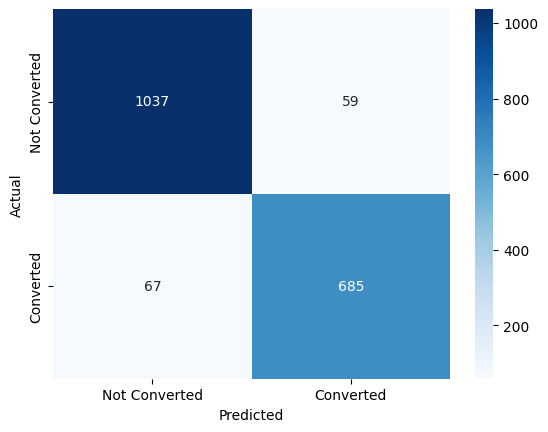

Accuracy: 0.9318181818181818
Precision: 0.9206989247311828
Recall: 0.910904255319149
F1 Score: 0.9157754010695187


In [16]:
# after fine-tune
st = time.time()

best_model = {'grid': 3, 'k': 7, 'step': 75, 'lamb': 0, 'lamb_entropy': 0.01}

model = KAN(width=[dataset['train_input'].shape[1], 3, 1], grid=best_model['grid'], k=best_model['k'], device=device).to(device)
final_result = model.train(dataset, opt="LBFGS", steps=best_model['step'], lamb=best_model['lamb'], lamb_entropy=best_model['lamb_entropy'], metrics=(train_acc, test_acc), device=device)

et = time.time()
duration = et-st

print("Accuracy", final_result['train_acc'][-1], final_result['test_acc'][-1])
print("Duration", duration)

# get predicted values
with torch.no_grad():
    test_inputs = dataset['test_input'].clone().detach().to(device)
    actual_labels = dataset['test_label'].clone().detach().to(device)
    predicted_probs = model(test_inputs)
    predicted_labels = (predicted_probs > 0.5).float()
    
y_pred = predicted_labels.cpu().numpy()
y_true = actual_labels.cpu().numpy()

conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

accuracy = (tn+tp)/(tn+fp+fn+tp)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# confusion matrix heatmap
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# performance metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')

In [17]:
# save to csv
filename = "30.csv"
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Metric", "Before", "After"])
    writer.writerow(["Accuracy", accuracy_b4, accuracy])
    writer.writerow(["Precision", precision_b4, precision])
    writer.writerow(["Recall", recall_b4, recall])
    writer.writerow(["F1 Score", f1_score_b4, f1_score])
    writer.writerow(["Duration", duration_b4, duration])